In [42]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import pickle
import time

In [43]:
seed = 47

In [44]:
BATCH_SIZE = 32
IMG_SIZE = (35, 70)
path = 'parking/clf-data'

train_dataset, validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(path, labels="inferred", image_size=IMG_SIZE, validation_split=.2, subset='both', seed=seed)

# train, test = tf.keras.utils.split_dataset(dataset=data, left_size=.8, shuffle=True, seed=seed)
# tf.keras.preprocessing.
# print(type(data))

# len(data.)

Found 6090 files belonging to 2 classes.
Using 4872 files for training.
Using 1218 files for validation.


2024-06-14 11:56:34.447456: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


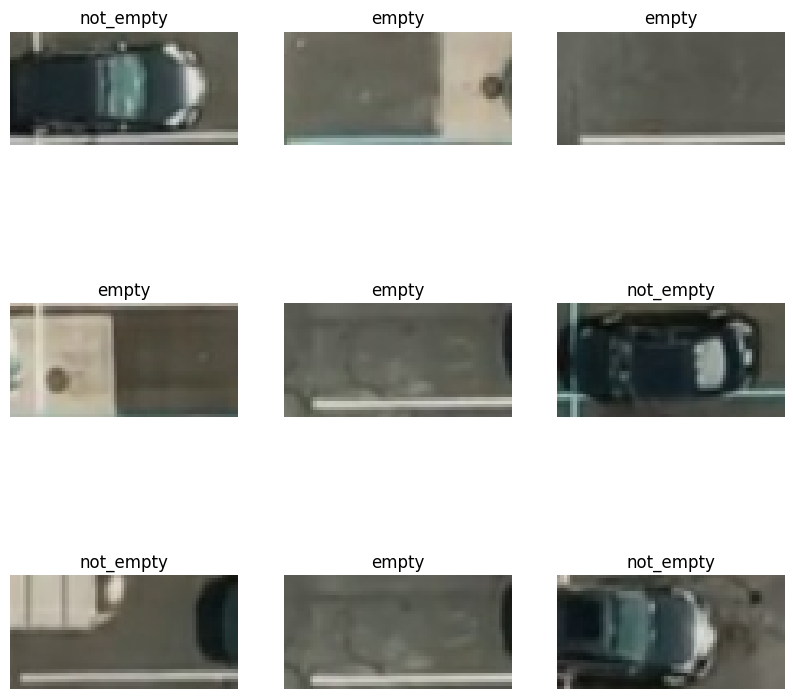

In [45]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [46]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [47]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 32
Number of test batches: 7


In [48]:
# Using prefetch as per https://www.tensorflow.org/guide/data_performance 
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [49]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  # tf.keras.layers.RandomRotation(0.2),
])

2024-06-14 11:56:34.701414: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


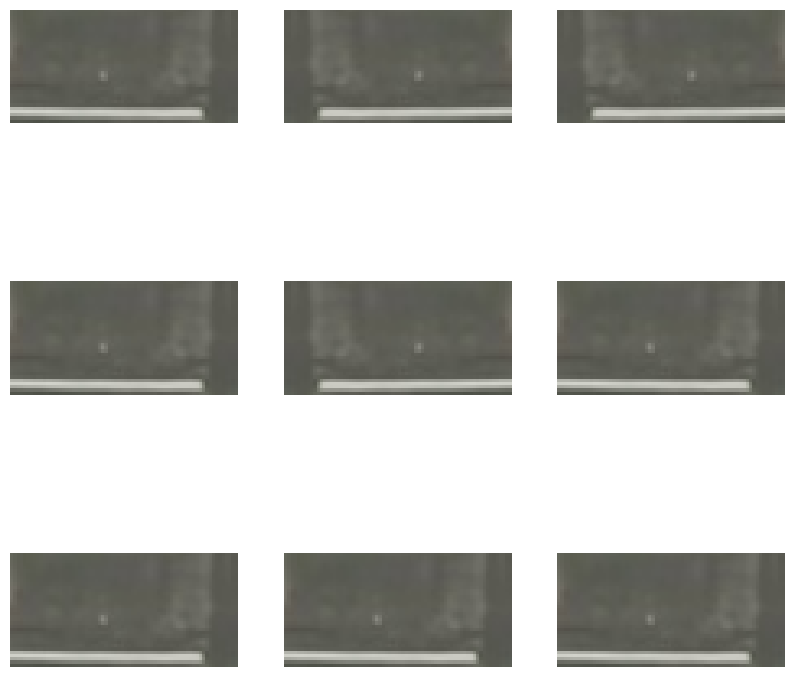

In [50]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [51]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [52]:
# rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [53]:
# Create the base model from a pre-trained model (MobileNet V2, InceptionV3, EfficientNetB7 etc)
IMG_SHAPE = IMG_SIZE + (3,)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

/var/folders/0r/tspq5j2s2fv0zp31f7l4m0_c0000gn/T/ipykernel_68993/589291425.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,


In [54]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 2, 3, 1280)


In [55]:
base_model.trainable = False

In [56]:
# Let's take a look at the base model architecture
# base_model.summary()

In [57]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [58]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [59]:
inputs = tf.keras.Input(shape=(35, 70, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [60]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 35, 70, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 35, 70, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 35, 70, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 35, 70, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 2, 3, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [61]:
# tf.keras.utils.plot_model(model, show_shapes=True)

In [62]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
            #   metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])
                metrics = [tf.keras.metrics.R2Score()])

In [63]:
initial_epochs = 10

In [64]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 1.0304 - r2_score: -0.3278 - val_loss: 0.3250 - val_r2_score: 0.6168
Epoch 2/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.3102 - r2_score: 0.6251 - val_loss: 0.1862 - val_r2_score: 0.8154
Epoch 3/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.1836 - r2_score: 0.8038 - val_loss: 0.1323 - val_r2_score: 0.8800
Epoch 4/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 0.1296 - r2_score: 0.8736 - val_loss: 0.1044 - val_r2_score: 0.9097
Epoch 5/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.1061 - r2_score: 0.9010 - val_loss: 0.0859 - val_r2_score: 0.9278
Epoch 6/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.0865 - r2_score: 0.9207 - val_loss: 0.0734 - val_r2_score: 0.9393
Epoch 7/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0753 - r2_score: 0.9318 - val_loss: 0.0636 - val_r2_score: 0.9477
Epoch 8/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.0632 - r2_score: 0.9448 - val_los

In [65]:
loss0, accuracy0 = model.evaluate(validation_dataset)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0492 - r2_score: 0.9569


In [66]:
print("loss: {:.2f}".format(loss0))
print("accuracy: {:.2f}".format(accuracy0))

loss: 0.04
accuracy: 0.96


In [67]:
# ofname = open('model_MobileNetV2_2.pkl', 'wb')
# s = pickle.dump(model,ofname)
# ofname.close()
# print(s)

In [68]:
# ifname = open('model.pkl','rb')
# new_model = pickle.load(ifname)
# print(new_model)

In [69]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

KeyError: 'accuracy'

In [70]:
base_model.trainable = True

In [71]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [72]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [73]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 35, 70, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 35, 70, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 35, 70, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 35, 70, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 2, 3, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,862,721 (7.11 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [74]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=validation_dataset)

Epoch 11/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.8531 - loss: 0.3432 - val_accuracy: 0.9849 - val_loss: 0.0397
Epoch 12/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.9810 - loss: 0.0832 - val_accuracy: 0.9809 - val_loss: 0.0407
Epoch 13/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.9943 - loss: 0.0312 - val_accuracy: 0.9819 - val_loss: 0.0358
Epoch 14/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.9952 - loss: 0.0229 - val_accuracy: 0.9839 - val_loss: 0.0294
Epoch 15/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.9978 - loss: 0.0118 - val_accuracy: 0.9920 - val_loss: 0.0183
Epoch 16/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.9977 - loss: 0.0090 - val_accuracy: 0.9950 - val_loss: 0.0118
Epoch 17/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.9971 - loss: 0.0104 - val_accuracy: 0.9980 - val_loss: 0.0075
Epoch 18/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.9992 - loss: 0

In [75]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

TypeError: unsupported operand type(s) for +=: 'float' and 'list'

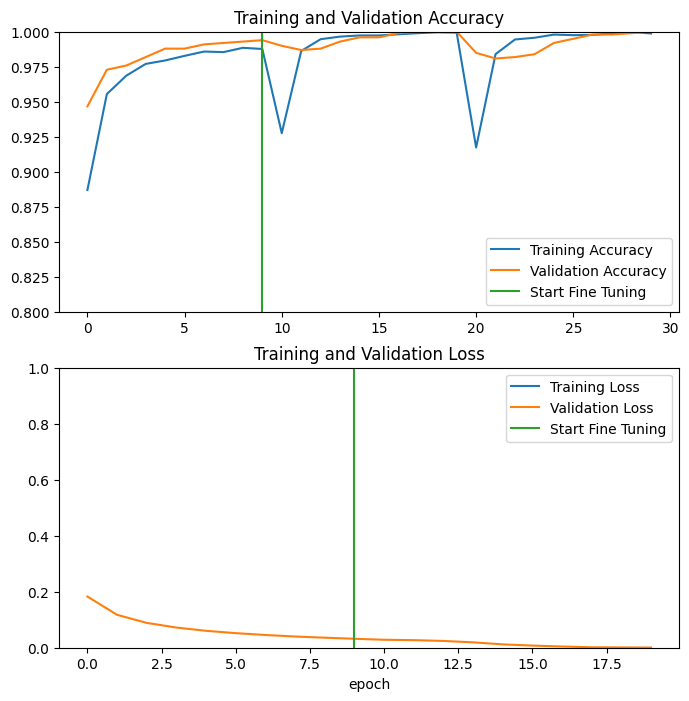

In [76]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [77]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 6.8565e-04
Test accuracy : 1.0


Predictions:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Labels:
 [1 0 0 1 1 0 0 1 1 1 1 0 1 0 1 1 0 0 1 1 0 1 1 0 1 1 1 1 0 1 1 1]


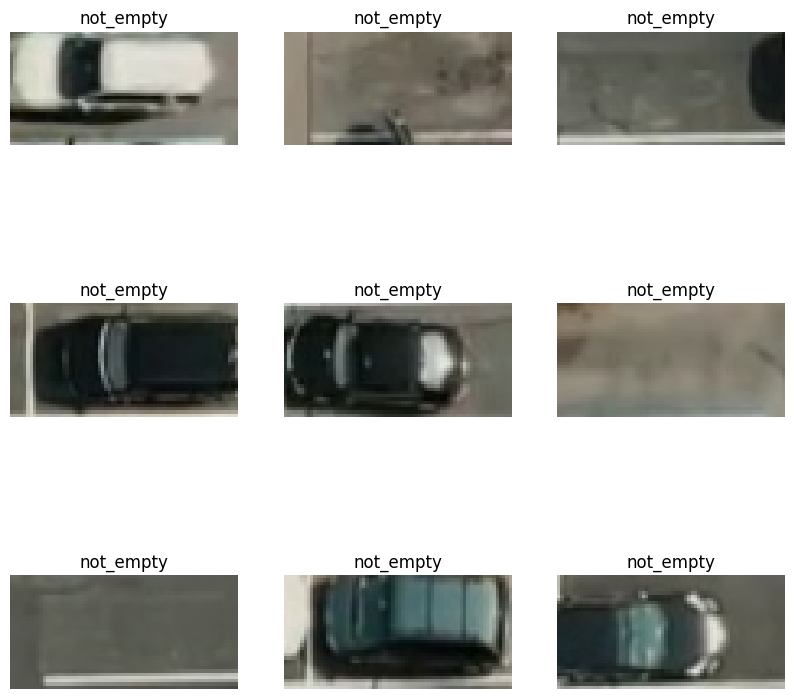

In [78]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [79]:
ofname = open('model_MobileNetV2_4.pkl', 'wb')
s = pickle.dump(model,ofname)
ofname.close()
print(s)

None
